# Rice Leaf Diseases: Implementing a Custom Model

This notebook will continue our exploration of the [Rice Leaf Diseases dataset from Kaggle](https://www.kaggle.com/vbookshelf/rice-leaf-diseases).  

In this notebook, we will do the following:

1. Create a CNN-based classifier network similar to [1].
3. Train the network directly on our rice image dataset (training partition), using lots of image augmentation to prevent overfitting.
4. Predict on the testing partition, and display results with a confusion matrix and classification report.

[1]: Wick, C. & Puppe, F. Leaf Identification Using a Deep Convolutional Neural Network. arXiv:1712.00967 [cs] (2017).

## Setting up your environment
Before running this notebook, you will need to make sure you have [downloaded](https://www.kaggle.com/vbookshelf/rice-leaf-diseases) the dataset and extracted the files.  This notebook assumes the image data is extracted in the same directory as this notebook, and that the top-level data directory is named "rice_leaf_diseases".  You can edit the code if those assumptions do not hold on your own setup.

## Python environment
You will need the following packages installed to execute the code shown in this notebook:

* [Matplotlib](https://matplotlib.org/)
* [Numpy](https://numpy.org/)
* [Pandas](https://pandas.pydata.org/)
* [Scikit-Learn](https://scikit-learn.org/)
* [Tensorflow](https://www.tensorflow.org/)

## Local directory structure
This notebook assumes you have the rice leaf images in the following directory structure:

    rice_leaf_diseases/
        Bacterial leaf blight/
        Brown spot/
        Leaf smut/

The "ground truth" file "_rice_leaf_diseases_ground_truth.csv_" was created in the previous ("rice_image_EDA") notebook.  If you don't have this file, you can create it by running the first several cells in that notebook, which is available [by clicking here](https://gist.github.com/jcausey-astate/207ba4d65126abe0482b740b41117f9e).

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.metrics as metrics
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

First, we will create a function that will actually define the structure of the network.  We use Wick et al. (2017) as a guide, and fill in the missing details with common choices (activations, amount of dropout, etc.).

In [2]:
def build_leaf_classifier_model(input_shape=(256,256,3), n_classes=3):
    '''
    This function builds a Keras CNN similar to the one described in Wick et al. (2017).
    '''
    lrelu = keras.layers.LeakyReLU()
    input = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(40, (3,3), activation=lrelu, padding='same', name="conv1")(input)
    x = keras.layers.MaxPool2D((2,2), name='max_pool1')(x)
    x = keras.layers.Conv2D(40, (4,4), activation=lrelu, padding='same', name='conv2')(x)
    x = keras.layers.MaxPool2D((2,2), name='max_pool2')(x)
    x = keras.layers.Conv2D(80, (4,4), activation=lrelu, padding='same', name='conv3')(x)
    x = keras.layers.MaxPool2D((2,2), name='max_pool3')(x)
    x = keras.layers.Conv2D(160, (4,4), activation=lrelu, padding='same', name='conv4')(x)
    x = keras.layers.MaxPool2D((2,2), name='max_pool4')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(500, activation=lrelu)(x)
    x = keras.layers.Dropout(0.20)(x)
    x = keras.layers.Dense(n_classes, activation='softmax')(x)
    return keras.Model(inputs=input, outputs=x)

Let's create an instance of the model and see the summary:

In [3]:
leaf_model = build_leaf_classifier_model()
leaf_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 40)      1120      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 128, 128, 40)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 40)      25640     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 64, 64, 40)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 80)        51280     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 32, 32, 80)        0     

This model has almost 21 million parameters, which is a bit high for training directly with such a small amount of training data available, but it will give us a good baseline for how well the model can do.

We will train the model from scratch using more or less the same strategy we used with the previous transfer learning example (except for the transfer learning part, of course).

Let's load the dataset and use `StratifiedShuffleSplit` to create an 80/20 train/test split:

In [4]:
ground_truth_df = pd.read_csv("rice_leaf_diseases_ground_truth.csv")
ground_truth_df.head()
sss = StratifiedShuffleSplit(1, test_size=0.20, random_state=2021)
train_indices, test_indices = list(sss.split(ground_truth_df.values, ground_truth_df['class'].values))[0]
print(f"Training set has {train_indices.shape[0]} samples.")
print(f"Test set has {test_indices.shape[0]} samples.")

Training set has 96 samples.
Test set has 24 samples.


Now we will set up our image data generators for training and testing.

The training generator will not do any augmentation.  It will only scale the image to contain values in the $[0,1]$ numeric range.

The test generator will perform several kinds of augmentation, in addition to rescaling the image to $[0,1]$: 



In [5]:
# Declare the generator (we will take default initial paramters for now)
test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=60,
    width_shift_range=0.20,
    height_shift_range=0.10,
    zoom_range=0.2,
    brightness_range=(0.5, 1.25),
)

The following cell will create a "flow" object that will actually become the sequence of values we feed into the model for training and testing.  

The main difference between the two "flows" is that the "train" version must use only the _training_ rows from the ground truth, and the "test" version uses only the _test_ rows.

In [6]:
BATCH_SIZE = 32
train_dataflow = train_generator.flow_from_dataframe(
    ground_truth_df.iloc[train_indices,:],
    x_col = "image_path",
    y_col = "class",
    target_size = (256,256),
    shuffle = True,
    seed = 2021,
    batch_size=BATCH_SIZE,
)
test_dataflow = test_generator.flow_from_dataframe(
    ground_truth_df.iloc[test_indices,:],
    x_col = "image_path",
    y_col = "class",
    target_size = (256,256),
    shuffle = False,
    seed = 2021,
    batch_size=BATCH_SIZE,
)
class_to_int = test_dataflow.class_indices
image_classes = sorted(class_to_int.keys())

Found 96 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.


Now we can compile and train.  We will train for 30 epochs here.

In [7]:
leaf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
leaf_model.fit(
    train_dataflow,
    validation_data=test_dataflow,
    epochs=30,
    batch_size=BATCH_SIZE
)

Epoch 1/30
3/3 [==============================] - 8s 3s/step - loss: 3.7391 - acc: 0.3854 - val_loss: 3.2986 - val_acc: 0.3333
Epoch 2/30
3/3 [==============================] - 6s 2s/step - loss: 2.7144 - acc: 0.2812 - val_loss: 1.4589 - val_acc: 0.3333
Epoch 3/30
3/3 [==============================] - 6s 2s/step - loss: 1.2251 - acc: 0.3542 - val_loss: 1.1923 - val_acc: 0.4167
Epoch 4/30
3/3 [==============================] - 6s 2s/step - loss: 1.1523 - acc: 0.3854 - val_loss: 1.0745 - val_acc: 0.3750
Epoch 5/30
3/3 [==============================] - 7s 2s/step - loss: 1.1059 - acc: 0.4375 - val_loss: 1.0091 - val_acc: 0.5000
Epoch 6/30
3/3 [==============================] - 6s 2s/step - loss: 1.0757 - acc: 0.4062 - val_loss: 1.1515 - val_acc: 0.4167
Epoch 7/30
3/3 [==============================] - 6s 2s/step - loss: 1.1265 - acc: 0.3958 - val_loss: 1.0421 - val_acc: 0.3750
Epoch 8/30
3/3 [==============================] - 6s 2s/step - loss: 1.1556 - acc: 0.3438 - val_loss: 1.0186 - 

Now, we have trained the model for a bit - let's see how the accuracy actually looks with our previous metrics:

In [8]:
gt_classes = test_dataflow.classes
print(gt_classes)

[2, 2, 2, 1, 0, 1, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 2, 1, 0, 0, 2, 0]


In [9]:
predictions = leaf_model.predict(test_dataflow)
predicted_classes = list(np.argmax(predictions, axis=1))
print(predicted_classes)

[1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1]


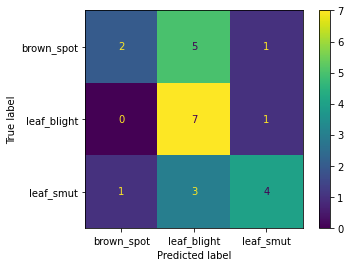

In [10]:
metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(gt_classes, predicted_classes), 
    display_labels=image_classes
).plot()

In [11]:
print(metrics.classification_report(gt_classes, predicted_classes, target_names=image_classes))

              precision    recall  f1-score   support

  brown_spot       0.67      0.25      0.36         8
 leaf_blight       0.47      0.88      0.61         8
   leaf_smut       0.67      0.50      0.57         8

    accuracy                           0.54        24
   macro avg       0.60      0.54      0.51        24
weighted avg       0.60      0.54      0.51        24



The performance still isn't great, but we can see that it is in the same range as our previous attempt at transfer learning with a very large model.   We might be able to squeeze more performance out of this one by using transfer learning from a similar data set...

What do you think?

---

_Note:_ You may also notice that there was one epoch where the validation performance reached ~70%!  If we had saved weights at that moment, we would have had a better performing model -- on this test set...  Does that mean it would perform better on new rice images?  Probably not.  Be careful about selecting a model based on one epoch where the validation performance is high.  It could have just been a "lucky" set of weights on that epoch.  To _really_ solve this problem, we need to do two things.  1) Use a third partition for the validation set during training.  Only evaluate the test set after we've chosen what we think is our best model.  2) Repeat this process using cross-validation to see how well it generalized.  We acknowledge that cross-validation is time and cost-prohibitive, but it is best-practice when you can afford to do it.